# Regression
## Acquisition and Prep 

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away.
Your goal is to predict the values of single unit properties using the obervations from 2017.

In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.


Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

### Exercises II

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import acquire

## 1. Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

In [4]:
df = acquire.new_zillow_data()

In [5]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [6]:
df.shape

(2152863, 7)

## 2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

### Do I like the column names?

In [7]:
# check the column names
df.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips'],
      dtype='object')

In [8]:
# renaming columns
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'sqft',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})

In [9]:
df.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


# Variable Distributions

*********************************************************

### Histographs

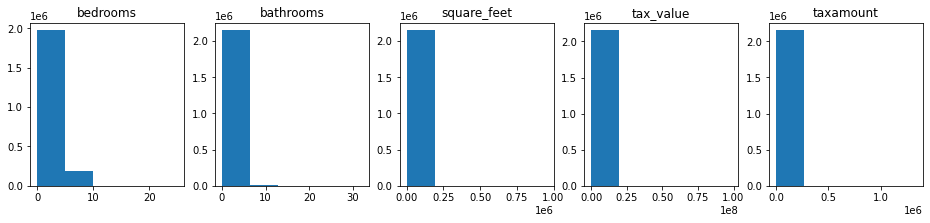

In [10]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
plt.show()

### Boxplot

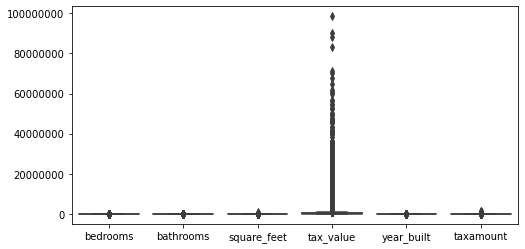

In [11]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['fips']))

plt.show()

## Takeaways for both sets of charts
- Extream outliers exist in the data and need to be removed
- Im going to use the iqr rule to remove outliers

In [12]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [13]:
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'taxamount'])
df

,bedrooms,bathrooms,square_feet,tax_value,year_built,taxamount,fips
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
18,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037.0
19,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037.0
20,3.0,2.0,1222.0,290492.0,1951.0,3870.25,6037.0
...,...,...,...,...,...,...,...
2152852,3.0,2.0,1917.0,408680.0,1946.0,4341.32,6111.0
2152853,4.0,2.0,1987.0,259913.0,1955.0,3175.66,6059.0
2152855,3.0,2.5,1809.0,405547.0,2012.0,4181.10,6059.0
2152861,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


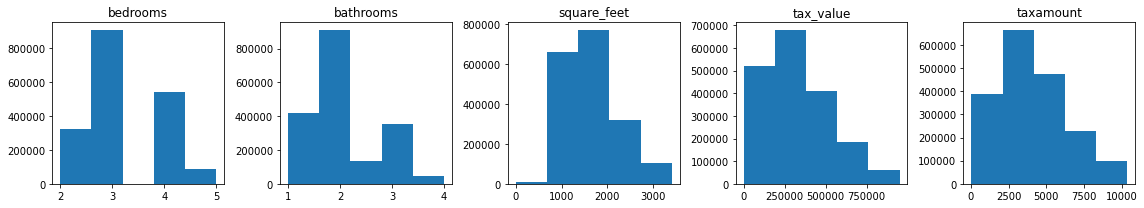

In [14]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
    # mitigate overlap
    plt.tight_layout()
    
plt.show()

### Takeaways
- Bedrooms, bathrooms, and squre_feet are not normally distributed 

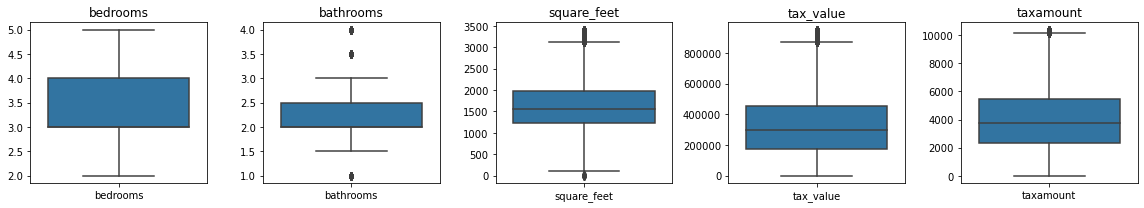

In [15]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'square_feet', 'tax_value', 'taxamount']

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

### Takeaways
- some exstream values are still present in the data
***************************************************************************************
## Prepare
- Are there any null values?

In [16]:
# get total of null values for each row
df.isnull().sum()

bedrooms         0
bathrooms        0
square_feet      0
tax_value        0
year_built     874
taxamount        0
fips             0
dtype: int64

In [17]:
# consider imputing year built
df.year_built.value_counts()

1955.0    80451
1950.0    66876
1954.0    65523
1953.0    58746
1956.0    58054
          ...  
1855.0        1
1874.0        1
1807.0        1
1833.0        1
1823.0        1
Name: year_built, Length: 152, dtype: int64

- because of the small number of missing rows I plan to impute year_built with the most frequent year after the data is split

*********************************************************************************************************
## Are the column data types correct? 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855285 entries, 6 to 2152862
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   bedrooms     float64
 1   bathrooms    float64
 2   square_feet  float64
 3   tax_value    float64
 4   year_built   float64
 5   taxamount    float64
 6   fips         float64
dtypes: float64(7)
memory usage: 113.2 MB


In [19]:
# get value counts and decide on data types
cols = df.columns

for col in cols:
    
    print(col.upper())
    print(df[col].value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()

BEDROOMS
3.0    905249
4.0    539886
2.0    320685
5.0     89465
Name: bedrooms, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

BATHROOMS
2.00    909673
1.00    385962
3.00    352086
2.50    132451
4.00     31976
1.50     30752
3.50     12382
1.75         3
Name: bathrooms, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

SQUARE_FEET
1200.0    5091
1080.0    4318
1120.0    4287
1400.0    3776
1440.0    3618
          ... 
404.0        1
430.0        1
471.0        1
317.0        1
462.0        1
Name: square_feet, Length: 3015, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

TAX_VALUE
450000.0    806
500000.0    754
400000.0    701
430000.0    677
475000.0    671
           ... 
877774.0      1
172618.0      1
581746.0      1
205760.0      1
366635.0      1
Name: tax_value, Length: 457592, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

YEAR_BUILT
1955.0    80451
1950.0    66876
1954.0    65523
1953.0    58746
1956.0    58054
          ...  
1855.0        1
1874.0        1


- casting fips and year built as an object because it is a numerical representation of a catagorical value
leaving the rest as floats

In [20]:
df.fips = df.fips.astype(object)
df.year_built = df.year_built.astype(object)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855285 entries, 6 to 2152862
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   bedrooms     float64
 1   bathrooms    float64
 2   square_feet  float64
 3   tax_value    float64
 4   year_built   object 
 5   taxamount    float64
 6   fips         object 
dtypes: float64(5), object(2)
memory usage: 113.2+ MB


## Do my columns contain target leak?
- The way I interpret taxamount is that it is the amount of tax paid on the property
- Because it would be impossible to calculate taxamount without first knowing the tax_value we will not have that knowledge at the time we are predicting tax_value
- Therefore we cannot use taxamount to predict tax_value
- I am dropping taxamount

In [22]:
df = df.drop(columns=['taxamount'])

## Split the data 

In [23]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

### Impute year_built with mode 

In [24]:
imputer = SimpleImputer(strategy='most_frequent')  # build imputer

imputer.fit(train[['year_built']]) # fit to train

# transform the data
train[['year_built']] = imputer.transform(train[['year_built']])
validate[['year_built']] = imputer.transform(validate[['year_built']])
test[['year_built']] = imputer.transform(test[['year_built']])

In [25]:
train.isnull().sum()

bedrooms       0
bathrooms      0
square_feet    0
tax_value      0
year_built     0
fips           0
dtype: int64

In [26]:
validate.isnull().sum()

bedrooms       0
bathrooms      0
square_feet    0
tax_value      0
year_built     0
fips           0
dtype: int64

In [45]:
test.isnull().sum()

bedrooms       0
bathrooms      0
square_feet    0
tax_value      0
year_built     0
fips           0
dtype: int64

In [46]:
train

,bedrooms,bathrooms,square_feet,tax_value,year_built,fips
10057,4.0,2.0,1561.0,248240.0,1973.0,6059.0
2004969,3.0,2.0,1770.0,88390.0,1960.0,6037.0
306031,2.0,1.0,1452.0,81169.0,1946.0,6037.0
1038594,3.0,1.0,1000.0,119174.0,1950.0,6037.0
270959,3.0,2.0,1974.0,432268.0,1988.0,6037.0
...,...,...,...,...,...,...
991121,3.0,1.0,1199.0,280857.0,1951.0,6111.0
1707758,4.0,2.0,1859.0,95008.0,1961.0,6037.0
1770245,3.0,3.0,2132.0,158470.0,1980.0,6037.0
1500740,2.0,1.0,780.0,477167.0,1955.0,6037.0


In [49]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,1038959.0,3.214004,0.781049,2.0,3.0,3.0,4.0,5.0
bathrooms,1038959.0,2.053663,0.707839,1.0,2.0,2.0,2.5,4.0
square_feet,1038959.0,1653.719097,564.247247,1.0,1232.0,1548.0,1987.0,3410.0
tax_value,1038959.0,327962.928757,198987.574520,22.0,173843.5,296624.0,452514.0,950940.0
year_built,1038959.0,1959.441559,20.533659,1812.0,1949.0,1957.0,1972.0,2016.0


## 3.  Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

In [ ]:
'''Wrangles data from Zillow Database'''

##################################################Wrangle.py###################################################

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from env import user, password, host

#**************************************************Acquire*******************************************************

def acquire_zillow():
    ''' Acquire data from Zillow using env imports and rename columns'''
    
    url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
    query = """
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017

    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")"""

    # get dataframe of data
    df = pd.read_sql(query, url)
    
    
    # renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built',})
    return df

#**************************************************Remove Outliers*******************************************************

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

#**************************************************Distributions*******************************************************

def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()
        
        
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()
        
#**************************************************Prepare*******************************************************

def prepare_zillow(df):
    ''' Prepare zillow data for exploration'''

    # removing outliers
    df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount'])
    
    # get distributions of numeric data
    get_hist(df)
    get_box(df)
    
    # converting column datatypes
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)
    
    # drop taxamount
    df = df.drop(columns = 'taxamount')
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute year built using mode
    imputer = SimpleImputer(strategy='most_frequent')

    imputer.fit(train[['year_built']])

    train[['year_built']] = imputer.transform(train[['year_built']])
    validate[['year_built']] = imputer.transform(validate[['year_built']])
    test[['year_built']] = imputer.transform(test[['year_built']])       
    
    return train, validate, test    

#**************************************************Wrangle*******************************************************

def wrangle_zillow():
    '''Acquire and prepare data from Zillow database for explore'''
    train, validate, test = prepare_zillow(acquire_zillow())
    
    return train, validate, test